In [1]:
%matplotlib inline
from common.w2v_model import W2VModel
from training_tools.train_models import train_models
from training_tools.evaluate_models import evaluate_models
from training_tools.helpers.plotting import load_results, plot_metrics
from training_tools.normalize_and_align_models import normalize_and_align_vectors
from training_tools.helpers.plotting import load_results, plot_metrics

# **Train `Word2vec` Models**
## **Goal**: Train word embeddings using the `Word2vec` algorithm. 

If you have successfully run the two previous workflows (`workflow_unigrams.ipynb` and `workflow_multigrams.ipynb`), then you are in possession of pre-processed yearly Google Ngram data. This workflow uses the `train_models.py` module to train year-specific models using [Word2Vec](https://en.wikipedia.org/wiki/Word2vec)—a popular technique for deriving [vector representations](https://en.wikipedia.org/wiki/Word_embedding) of the words in a corpus. You can then use the `evaluate_models.py` module to see how well your models have been trained.

Training word-embedding models requires decisions about various modeling parameters (i.e., hyperparameters). The most important are:

1. **`vector_size`**: the dimensionality of the vector space in which words are embedded. In essence, vector size is the number of words _in relation to which_ the model understands any particular word. More dimensions are not necessarily better. While too few dimensions can prevent the model from learning words' full meanings, too many dimensions risks overfitting or allowing low-frequency, specialized uses to obscure words' most important meanings.

2. **`window`**: the width of `word2vec`'s sliding context window. Word2vec reads in "sentences" (in this case, multigrams) and tries to learn probabilistic relationships between a target word and the words that surround it in the corpus. To the extent that two words have the same probabilistic relations to other nearby words, their vector representations will be similar. The `window` parameter determines what "nearby" means: With a window of 2, a word's meaning is defined strictly by the words immediately adjacent to it; with a window of 5, a word's meaning is determined by words up to four words away. Roughly speaking, models trained using a narrow context window will privilege _syntactic_ relationships, whereas models trained using a wider context window will do a better job learning _semantic_ relationships.

3. **`approach`**: the training architecture to use. You can specify either `CBOW` (Continuous Bag of Words) or `skip-gram`. In CBOW, context words are used to predict target words; in `skip-gram`, target words are used to predict context words. `skip-gram` tends to yield better results with ngrams.

4. **`min_count`**: the minimum number of times a word must appear in the corpus to be used for training. You may wish to ignore extremely infrequent words—especially in large corpora. This parameter lets you do that.

5. **`weight_by`**: the strategy for weighting ngrams by their frequency in the corpus. `none` means that no weighting is used and each unique ngram is fed to the model only once. `freq` gives ngrams a "bonus" if they appear multiple times; however the bonus diminishes as the frequency increases. For example, an ngram appearing 100 times in the corpus will be fed to `word2vec` twice, an ngram appearing 1,000 times is fed to the model 3 times, an ngram appearing 10,000 is fed to the model 4 times, and so on. The `doc_freq` option does the same thing, but using the number of unique _documents_ ngrams appear in. The goal of weighting is to allow somewhat frequent ngrams to influence the model more than rare ones—while not letting extremely frequent ngrams skew the model.

6. **`epochs`**: the number of training passes over the corpus. Too many can lead to overfitting, while too few can lead to imprecise embeddings. Experiment to see which values lead to the best model performance.

The other options are straightforward. `proj_dir` is the base directory for your project, `years=([start_year], [end_year])` specifies which yearly models to train, and `workers` is the number of CPU cores to use.

### Train and Evaluate 2019 Models to Optimize Parameters
Let's train a set of `Word2Vec` models on the most recent yearlty corpus (2019). This will help us identify optimal training parameters.

The `train_models.py` module can be used to iterate through multiple parameter combinations—allowing you to conduct a [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization). Thus, if you want to train models for 2018 and 2019 using vector sizes of 100, 200, and 300 and all three weighting strategies, you would specify `year=(2018, 2019)`, `weight_by=('none', 'freq', 'doc_freq')` and `vector_size=(100, 200, 300)`. The module would then train models using all combinations of these parameters, for a total of 18 models.

If you wish to train multiple sets of models, you may find it helpful to specify the `dir_suffix` option. This adds text to the end of the model directory, allowing you to keep sets of models separate.

#### First Training Pass
##### **Train**
We begin with a grid search varying vector size and the number of training epochs for the most recent yearly corpus (2019).

In [ ]:
train_models(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng-us/',
    dir_suffix='params1',
    years=(2019, 2019),
    weight_by=('none'),
    vector_size=(100, 200, 300, 400, 500),
    window=5,
    workers=14,
    min_count=(1),
    approach=('skip-gram'),
    epochs=(5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
)

Start Time:         2025-02-24 11:12:28.692936

Training Info
Data directory:     /vast/edk202/NLP_corpora/Google_Books/20200217/eng-us/5gram_files/6corpus/yearly_files/data
Model directory:    /vast/edk202/NLP_corpora/Google_Books/20200217/eng-us/5gram_files/6corpus/yearly_files/models_params1
Log directory:      /vast/edk202/NLP_corpora/Google_Books/20200217/eng-us/5gram_files/6corpus/yearly_files/logs_params1/training
Ngram size:         5
Number of workers:  14

Grid paramters:
  Weighting:           ('none',)
  Vector size:         (100, 200, 300, 400, 500)
  Context window:      (5,)
  Minimum word count:  (1,)
  Approach:            ('skip-gram',)
  Training epochs:     (5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)



Training Models:   0%|          | 0/55 [00:00<?, ?it/s]

##### **Evaluate**
The next step is to examine the quality of the trained models. The `evaluate_models.py` module performs two "intrinsic" tests on the models in your project's `models` directory: a similarity test and an analogy test. In a similarity test, models predict human-rated similarities between word pairs. In an analogy test, models attempt to answer questions of the form "_a_ is to _b_ as _c_ is to what?"—for example, "_king_ is to _queen_ as _man_ is to what?" (where the correct answer is _woman_).

By default, the code runs the similarity tests packaged with Gensim, but if you want to use different test items, you can by specifying the `similarity_dataset` and `analogy_dataset` options (making sure that the test files are properly formatted). You can specify the `dir_suffix` option to evaluate a certain set of trained models; this text will also be appended to the name of the file containing evaluation results. 

In [ ]:
evaluate_models(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/',
    dir_suffix='params1',
    eval_dir='/scratch/edk202/hist_w2v/training_results',
    save_mode='overwrite',
    workers=48
)

##### **Plot**
In addition inspecting the `evaluation_results.csv` file, we can plot the similarity and analogy scores for our first-pass models.

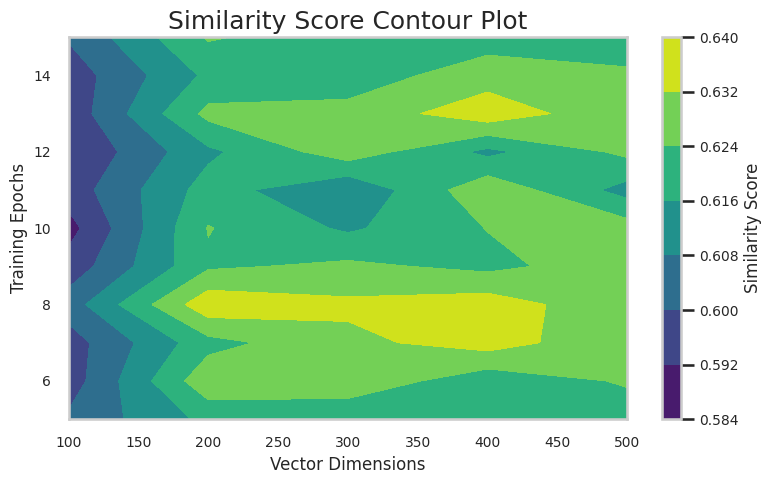

In [5]:
plot_metrics(
    df=load_results('../training_results/evaluation_results_params1.csv'),
    x_vars=['vector_size', 'epochs'],
    plot_type='contour',
    metric='similarity_score'
)

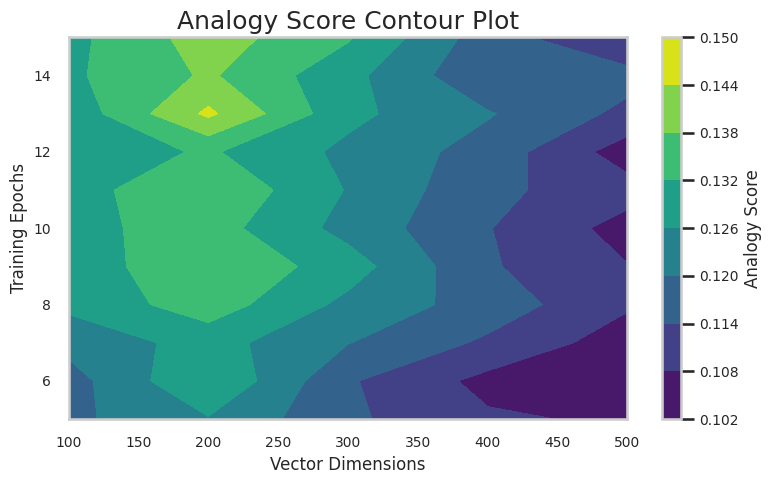

In [6]:
plot_metrics(
    df=load_results('../training_results/evaluation_results_params1.csv'),
    x_vars=['vector_size', 'epochs'],
    plot_type='contour',
    metric='analogy_score'
)

#### Second Training Pass
##### **Train**
We next run a second grid search to optimize the values of `weight_by` and `min_count`.

In [ ]:
train_models(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/',
    dir_suffix='params2',
    years=(2019, 2019),
    weight_by=('none', 'freq', 'doc_freq'),
    vector_size=(200),
    window=5,
    workers=14,
    min_count=(5, 10, 15, 20, 25, 30, 35, 40, 45, 50),
    approach=('skip-gram'),
    epochs=(8)
)

##### **Evaluate**
We now evaluate the second-pass models.

In [2]:
evaluate_models(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/',
    dir_suffix='params2',
    eval_dir='/scratch/edk202/hist_w2v/training_results',
    save_mode='append',
    workers=48
)

Start Time:            2025-02-07 13:44:41.037075

Evaluation Info
Ngram size:            5
Model directory:       /vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/5gram_files/6corpus/yearly_files/models_params2
Evaluation file path:  /scratch/edk202/hist_w2v/training_results/evaluation_results_params2.csv
Log directory:         /vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/5gram_files/6corpus/yearly_files/logs_params2/evaluation
Save mode:             append
Similarity dataset:    /ext3/miniforge3/lib/python3.12/site-packages/gensim/test/test_data/wordsim353.tsv
Analogy dataset:       /ext3/miniforge3/lib/python3.12/site-packages/gensim/test/test_data/questions-words.txt



Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

##### **Plot**
Here we plot the evaulation results.

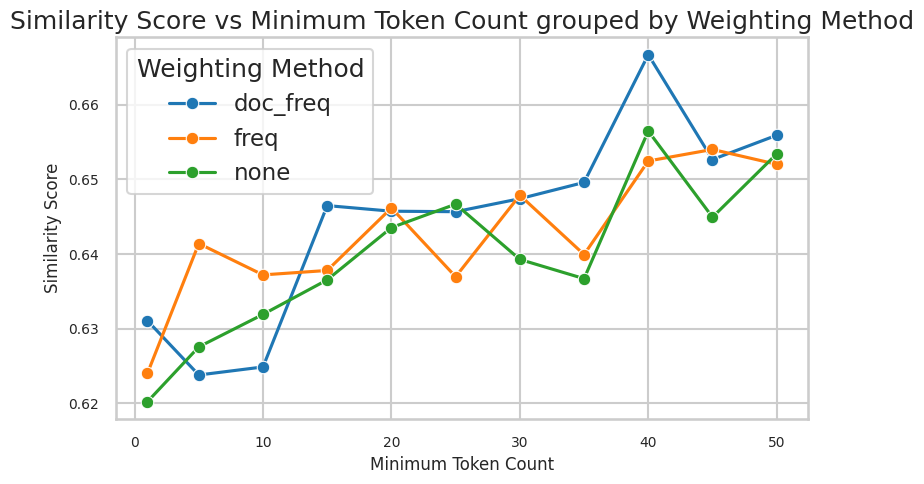

In [3]:
plot_metrics(
    df=load_results('../training_results/evaluation_results_params2.csv'),
    x_vars=['min_count', 'weight_by'],
    plot_type='line',
    metric='similarity_score'
)

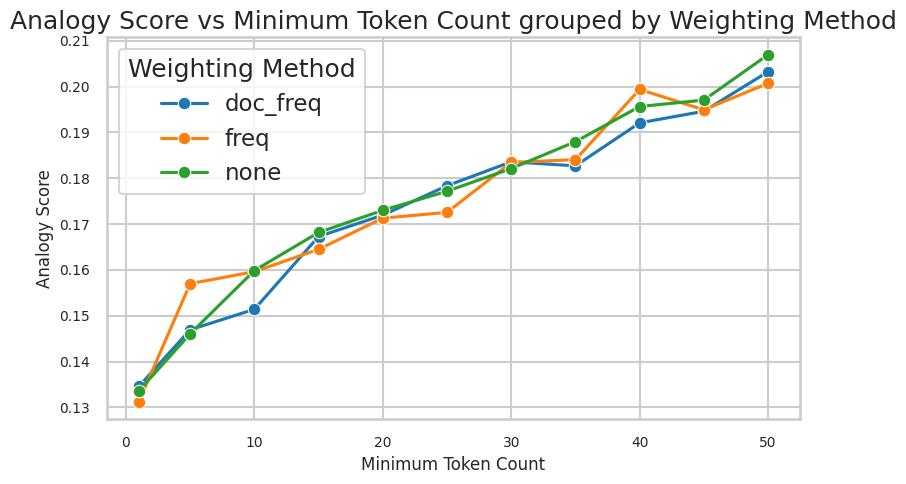

In [4]:
plot_metrics(
    df=load_results('../training_results/evaluation_results_params2.csv'),
    x_vars=['min_count', 'weight_by'],
    plot_type='line',
    metric='analogy_score'
)

### Train Historical `Word2Vec` Models

Once we have set of model parameters that we're happy with, we can proceed to train `word2vec` on multiple yearly corpora.

In [ ]:
train_models(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/',
    dir_suffix='final',
    years=(1578, 2019),
    weight_by=('none'),
    vector_size=(200),
    window=5,
    workers=14,
    min_count=(1),
    approach=('skip-gram'),
    epochs=(8)
)

Start Time:         2025-02-11 14:03:38.544579

Training Info
Data directory:     /vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/5gram_files/6corpus/yearly_files/data
Model directory:    /vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/5gram_files/6corpus/yearly_files/models_final
Log directory:      /vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/5gram_files/6corpus/yearly_files/logs_final/training
Ngram size:         5
Number of workers:  14

Grid paramters:
  Weighting:           ('none',)
  Vector size:         (200,)
  Context window:      (5,)
  Minimum word count:  (1,)
  Approach:            ('skip-gram',)
  Training epochs:     (8,)



Training Models:   0%|          | 0/442 [00:00<?, ?it/s]

In [3]:
normalize_and_align_vectors(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/',
    dir_suffix='final',
    anchor_year=2019
)

Saved normalized anchor model to /vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/5gram_files/6corpus/yearly_files/models_final/norm_and_align/w2v_y2019_wbnone_vs200_w5_mc1_sg1_e8.kv


Processing models:   0%|          | 0/387 [00:00<?, ?file/s]

Total runtime: 0:11:28.742884
Processed 388 models. Aligned to anchor year 2019.


In [10]:
model1 = W2VModel("/vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/5gram_files/6corpus/yearly_files/models_final/norm_and_align/w2v_y1718_wbnone_vs200_w5_mc1_sg1_e8.kv")
model2 = W2VModel("/vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/5gram_files/6corpus/yearly_files/models_final/norm_and_align/w2v_y2019_wbnone_vs200_w5_mc1_sg1_e8.kv")

# Ensure vocab is filtered before evaluation
reference_vocab = model1.extract_vocab().intersection(model2.extract_vocab())
model1.filter_vocab(reference_vocab)
model2.filter_vocab(reference_vocab)

# Evaluate alignment
alignment_results = model1.evaluate_alignment(model2)


---------------- Normalization and Alignment Evaluation ------------------
Model1 normalized: True
Model2 normalized: True
Shared vocabulary size: 477
Filtered vocabularies match: True
Shape of X (anchor model vectors): (477, 200)
Shape of Y (target model vectors): (477, 200)
Alignment deviation from identity: 0.000035
✅ Alignment deviation is minimal. Alignment likely successful.
Models are aligned (threshold 0.001): True
--------------------------------------------------------------------------



### Next Steps
If you have successfully training `word2vec` models on multiple years of Google Ngrams, it's time to analyze change in word representations using the `workflow_analyze_change.ipynb` notebook! That's when the real fun starts.